In [1]:
import pandas as pd
from sklearn.metrics import roc_auc_score
import numpy as np

In [2]:
# demand_bookings_df = pd.read_csv('./hotel_bookings.csv')
# demand_bookings_df.rename(columns = {
#     'adults': 'no_of_adults',
#     'children': 'no_of_children',
#     'stays_in_weekend_nights': 'no_of_weekend_nights',
#     'stays_in_week_nights': 'no_of_week_nights',
#     'meal': 'type_of_meal_plan',
#     'required_car_parking_spaces': 'required_car_parking_space',
#     'reserved_room_type': 'room_type_reserved',
#     'lead_time': 'lead_time',
#     'arrival_date_year': 'arrival_year',
#     'arrival_date_month': 'arrival_month',
#     'arrival_date_day_of_month': 'arrival_date',
#     'market_segment': 'market_segment_type',
#     'is_repeated_guest': 'repeated_guest',
#     'previous_cancellations': 'no_of_previous_cancellations',
#     'previous_bookings_not_canceled': 'no_of_previous_bookings_not_canceled',
#     'adr': 'avg_price_per_room',
#     'total_of_special_requests': 'no_of_special_requests',
#     'is_canceled': 'booking_status'
# }, inplace=True)

# demand_bookings_df['arrival_month'] = demand_bookings_df['arrival_month'].map({
#     'January': 1, 'February': 2, 'March': 3, 'April': 4,
#     'May': 5, 'June': 6, 'July': 7, 'August': 8,
#     'September': 9, 'October': 10, 'November': 11, 'December': 12
# })

# demand_bookings_df['type_of_meal_plan'] = \
#     demand_bookings_df['type_of_meal_plan'].map({
#         'BB': 0, 'HB': 2, 'SC': 1, 'Undefined': 1, 'FB': 3
#     })

# demand_bookings_df['market_segment_type'] = \
#     demand_bookings_df['market_segment_type'].map({
#         "'Online TA": 1, "Offline TA/TO": 0, "Corporate": 2, "Complementary": 4, "Aviation": 3
#     })

# demand_bookings_df['room_type_reserved'] = \
#     demand_bookings_df['room_type_reserved'].map({
#         'A':  0, 'D':  1, 'E':  3, 'F':  2, 'G':  4, 'B':  5, 'C':  6
#     })

# demand_bookings_df['market_segment_type'].fillna(5, inplace=True)
# demand_bookings_df['room_type_reserved'].fillna(7, inplace=True)

In [3]:
train = pd.read_csv('./train.csv').drop('id',axis=1)
cols = train.columns
origin = pd.read_csv('./archive/train__dataset.csv')
train = pd.concat([train,origin],axis=0).drop_duplicates().reset_index(drop=True) # demand_bookings_df
test = pd.read_csv('./test.csv').drop('id',axis=1)

In [4]:
train = train.loc[:,cols]
train

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,2,0,0,2,1,0,0,9,2018,1,14,1,1,11,0,67.50,0,0
1,2,0,1,2,0,0,0,117,2018,7,29,0,0,0,0,72.25,0,0
2,2,0,0,1,0,0,0,315,2018,12,2,0,0,0,0,52.00,0,0
3,1,0,0,2,1,0,0,32,2018,12,1,1,0,0,0,56.00,0,0
4,2,0,1,0,0,0,0,258,2018,10,16,0,0,0,0,100.00,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54568,2,0,1,1,2,0,0,35,2018,10,15,1,0,0,0,148.60,2,0
54569,2,0,0,5,0,0,0,205,2018,7,26,1,0,0,0,70.03,1,1
54570,2,0,0,1,0,0,0,90,2018,7,13,1,0,0,0,105.30,0,1
54571,2,0,0,3,0,0,0,18,2018,11,10,1,1,0,1,123.33,1,0


<AxesSubplot: ylabel='Frequency'>

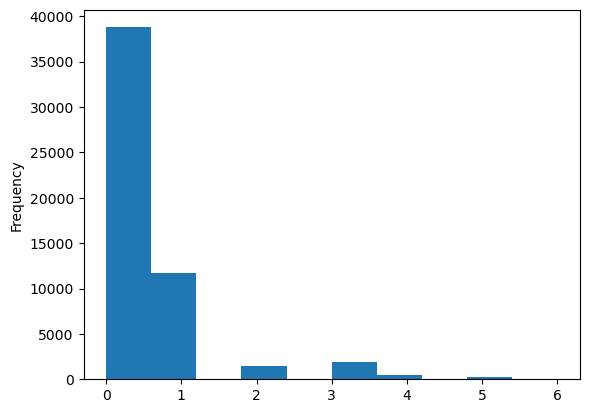

In [5]:
train.room_type_reserved.plot.hist()

In [6]:
drop_target = ['arrival_year','no_of_previous_cancellations']
train = train.drop(drop_target,axis=1)
test = test.drop(drop_target,axis=1)

In [7]:
train.booking_status.value_counts()

0    34612
1    19961
Name: booking_status, dtype: int64

In [8]:
from pycaret import classification
classification.setup(session_id=41,data=train,target='booking_status')

,Description,Value
0,session_id,41
1,Target,booking_status
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(54573, 16)"
5,Missing Values,False
6,Numeric Features,4
7,Categorical Features,11
8,Ordinal Features,False
9,High Cardinality Features,False


(10,
 False,
 '2528',
 -1,
 'clf-default-name',
 False,
 None,
 [('Setup Config',
                                  Description             Value
   0                               session_id                41
   1                                   Target    booking_status
   2                              Target Type            Binary
   3                            Label Encoded              None
   4                            Original Data       (54573, 16)
   5                           Missing Values             False
   6                         Numeric Features                 4
   7                     Categorical Features                11
   8                         Ordinal Features             False
   9                High Cardinality Features             False
   10                 High Cardinality Method              None
   11                   Transformed Train Set       (38201, 77)
   12                    Transformed Test Set       (16372, 77)
   13                 

In [9]:
best = classification.compare_models(sort='AUC',n_select=4,fold=10)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.8265,0.8970,0.7315,0.7807,0.7552,0.6210,0.6219,2.3150
catboost,CatBoost Classifier,0.8263,0.8966,0.7263,0.7833,0.7537,0.6198,0.6209,3.6430
lightgbm,Light Gradient Boosting Machine,0.8245,0.8942,0.7247,0.7803,0.7514,0.6161,0.6172,0.1440
gbc,Gradient Boosting Classifier,0.8136,0.8807,0.7003,0.7696,0.7333,0.5905,0.5921,1.4440
ada,Ada Boost Classifier,0.7967,0.8699,0.6971,0.7341,0.7150,0.5572,0.5577,0.4260
rf,Random Forest Classifier,0.8015,0.8652,0.6916,0.7475,0.7184,0.5655,0.5666,0.8730
lr,Logistic Regression,0.7873,0.8545,0.6594,0.7327,0.6941,0.5318,0.5336,1.9060
lda,Linear Discriminant Analysis,0.7836,0.8516,0.6547,0.7269,0.6889,0.5237,0.5254,0.2290
et,Extra Trees Classifier,0.7684,0.8149,0.6514,0.6962,0.6730,0.4940,0.4947,1.2130
knn,K Neighbors Classifier,0.7370,0.7764,0.5888,0.6570,0.6210,0.4205,0.4221,0.2580


In [10]:
best_tune = [classification.tune_model(i) for i in best]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8205,0.8901,0.7332,0.7661,0.7493,0.6095,0.6099
1,0.8236,0.8906,0.7403,0.7689,0.7544,0.6168,0.6171
2,0.8128,0.8849,0.7232,0.7550,0.7388,0.5930,0.5934
3,0.8186,0.8900,0.7146,0.7726,0.7425,0.6028,0.6039
4,0.8194,0.8910,0.7275,0.7670,0.7467,0.6065,0.6070
5,0.8267,0.8896,0.7339,0.7796,0.7561,0.6219,0.6226
6,0.8099,0.8829,0.7189,0.7511,0.7346,0.5867,0.5871
7,0.8157,0.8822,0.7246,0.7605,0.7421,0.5989,0.5993
8,0.8241,0.8931,0.7432,0.7685,0.7556,0.6183,0.6185


In [11]:
best_tune

[XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.9, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.001, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=4, max_leaves=None,
               min_child_weight=3, missing=nan, monotone_constraints=None,
               n_estimators=140, n_jobs=-1, num_parallel_tree=None,
               objective='binary:logistic', predictor=None, ...),
 LGBMClassifier(bagging_fraction=0.9, bagging_freq=1, boosting_type='gbdt',
                class_weight=None, colsample_bytree=1.0, feature_fraction=0.7,
                importance_type='split', learning_rate=0.2, max_depth=-1,
 

In [12]:
best_tune[0].get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': None,
 'base_score': None,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 0.9,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.001,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 4,
 'max_leaves': None,
 'min_child_weight': 3,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 140,
 'n_jobs': -1,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': 41,
 'reg_alpha': 0.4,
 'reg_lambda': 0.5,
 'sampling_method': None,
 'scale_pos_weight': 1.2,
 'subsample': 0.9,
 'tree_method': 'auto',
 'validate_parameters': None,
 'verbosity': 0}

In [13]:
best_tune[1].get_params()

{'depth': 6,
 'l2_leaf_reg': 20,
 'border_count': 254,
 'verbose': False,
 'random_strength': 0.6,
 'task_type': 'CPU',
 'n_estimators': 90,
 'random_state': 41,
 'eta': 0.5}

In [14]:
import catboost
params = best_tune[1].get_params()
cat = catboost.CatBoostClassifier(**params)
cat.fit(train.drop('booking_status',axis=1),train['booking_status'])
proba_cat = cat.predict_proba(test)

In [15]:
import xgboost
params = best_tune[0].get_params()
xgb = xgboost.XGBClassifier(**params)
xgb.fit(train.drop('booking_status',axis=1),train['booking_status'])
proba_xgb = xgb.predict_proba(test)

In [16]:
import lightgbm
params = best_tune[2].get_params()
lgb = lightgbm.LGBMClassifier(**params)
lgb.fit(train.drop('booking_status',axis=1),train['booking_status'])
proba_lgb = lgb.predict_proba(test)

In [17]:
proba = [proba_cat,proba_xgb,proba_lgb]
proba = [[j[1] for j in i] for i in proba]

<BarContainer object of 15 artists>

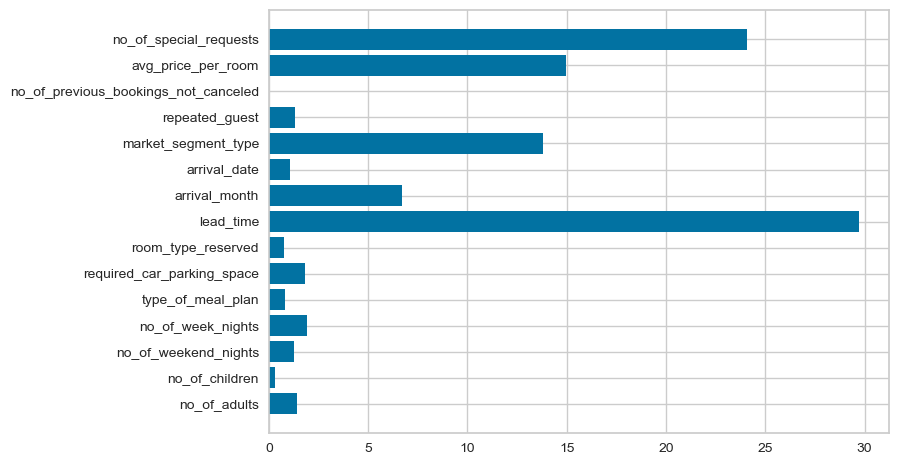

In [18]:
import matplotlib.pyplot as plt
plt.barh(cat.feature_names_,cat.feature_importances_)

<BarContainer object of 15 artists>

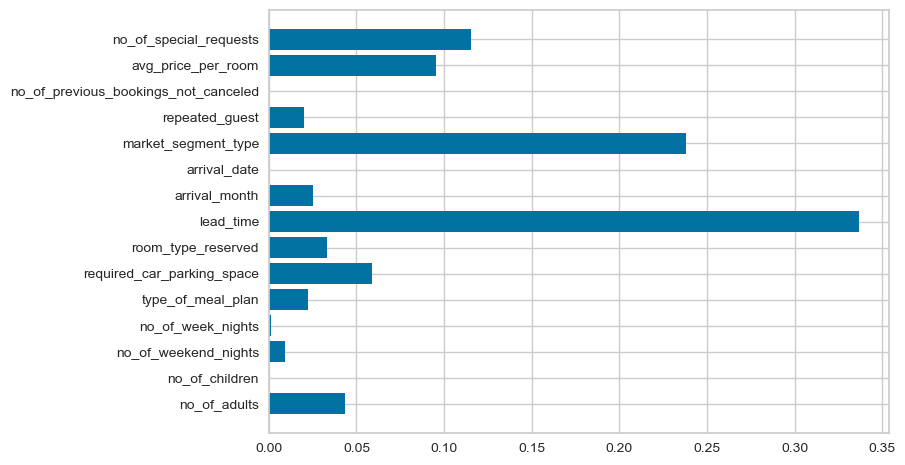

In [19]:
plt.barh(cat.feature_names_,xgb.feature_importances_)

<BarContainer object of 15 artists>

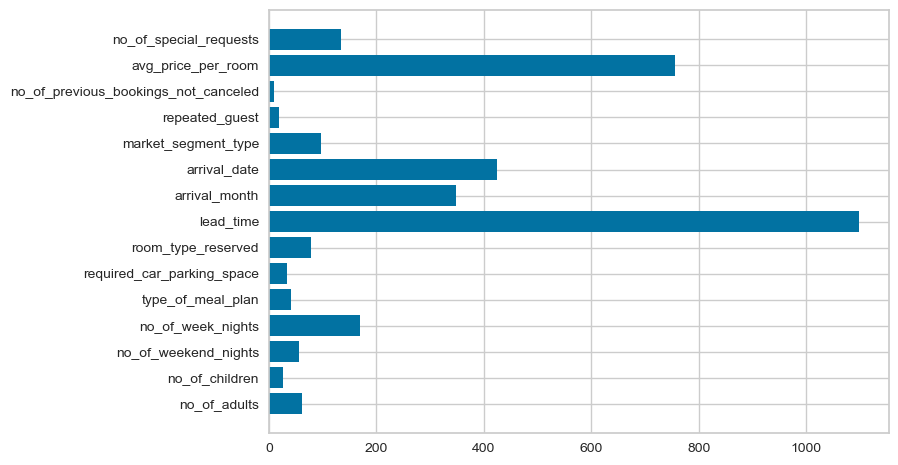

In [20]:
plt.barh(cat.feature_names_,lgb.feature_importances_)

In [24]:
best_tune

[XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.9, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.001, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=4, max_leaves=None,
               min_child_weight=3, missing=nan, monotone_constraints=None,
               n_estimators=140, n_jobs=-1, num_parallel_tree=None,
               objective='binary:logistic', predictor=None, ...),
 LGBMClassifier(bagging_fraction=0.9, bagging_freq=1, boosting_type='gbdt',
                class_weight=None, colsample_bytree=1.0, feature_fraction=0.7,
                importance_type='split', learning_rate=0.2, max_depth=-1,
 

In [40]:
sub = pd.read_csv('./sample_submission.csv')
sub['booking_status'] = 0.3*np.array(proba[0]) + 0.35*np.array(proba[1]) + 0.35*np.array(proba[2])# np.array(proba).mean(axis=0)
sub = sub.set_index('id')
sub.to_csv('./submission.csv')

In [41]:
sub

,booking_status
id,
42100,0.230007
42101,0.242854
42102,0.431986
42103,0.191222
42104,0.376218
...,...
70163,0.807577
70164,0.185191
70165,0.215363


<AxesSubplot: ylabel='Frequency'>

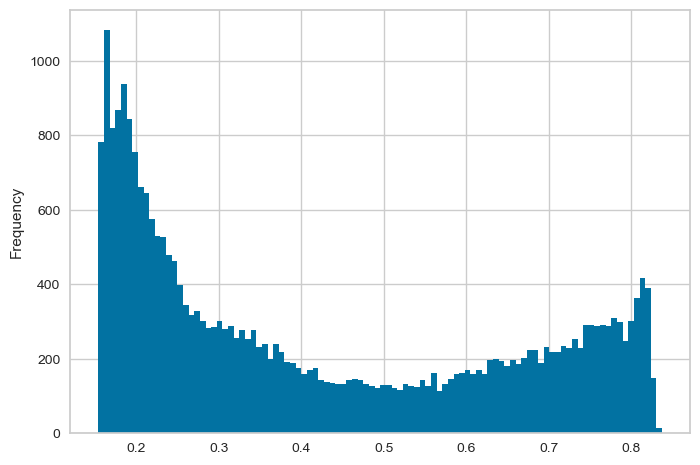

In [42]:
sub['booking_status'].plot.hist(bins=100)